In [1]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
from multiprocessing import Pool
import multiprocessing
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from functools import partial

import bus.analyzer as anz
import stay

In [15]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

station_usage_df = anz.parallel_load_total_usage_df(input_path_list, core=8)

# 데이터 로드
user_df = anz.load_user_df()
station_df = anz.load_station_df()
cluster_df = anz.load_cluster_df()
cluster_station_df = anz.load_cluster_station_df()

# 정류장 간 이동 데이터 -> 군집간 이동 데이터
cluster_usage_df = stay.create_cluster_usage_df(station_usage_df, cluster_station_df)

In [16]:
# 체류시간 추출
walk_df = stay.get_walk_df(cluster_usage_df)

In [17]:
# 결측값 제거
walk_df = walk_df.dropna()

In [18]:
# 관광객 데이터 추출
tourist_walk_df = stay.fillter_usage_df(walk_df, user_df, tourist=True)

In [19]:
# 관광객 체류시간 데이터 추출
walk_time_count_df = stay.analyze_walk_time_count(tourist_walk_df)

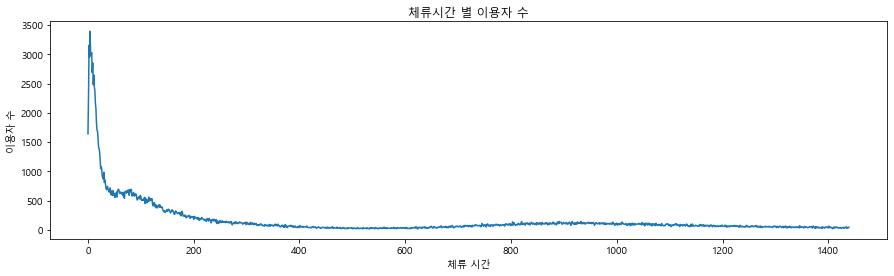

In [20]:
# 체류시간 데이터 시각화
x = walk_time_count_df['stay_time'].head(10000)
y = walk_time_count_df['num'].head(10000)
stay.draw_walk_time_count(x, y)

In [21]:
# position column 추가
tourist_walk_df = stay.set_position_columns(tourist_walk_df, cluster_df)

In [77]:
import math
    
def set_distance_column(df):
    d = math.pi*2*6371000/360
    
    df['dist_x'] = df['geton_cluster_longitude'] - df['getoff_cluster_longitude']
    df['dist_y'] = df['geton_cluster_latitude'] - df['getoff_cluster_latitude']
    
    df['dist_x'] = df['dist_x'].apply(lambda x : abs(x))
    df['dist_y'] = df['dist_y'].apply(lambda x : abs(x))
    
    df['distance'] = (df['dist_x']*df['dist_x'] + df['dist_y']*df['dist_y'])**0.5*d
    df['distance'] = df['distance'].apply(lambda x : int(x))
    df['distance'] = df['distance']
    return df

tourist_walk_df = set_distance_column(tourist_walk_df)

In [78]:
def get_walk_distance_df(walk_df):
    walk_df = walk_df['distance'].value_counts()
    walk_df = pd.DataFrame(walk_df)
    walk_df = walk_df.reset_index().rename(columns = {'index':'distance', 'distance':'num'})
    walk_df = walk_df.sort_values('distance')
    seletor = walk_df.columns
    walk_df = walk_df.reset_index()[seletor]
    return walk_df

walk_distance_df = get_walk_distance_df(tourist_walk_df)

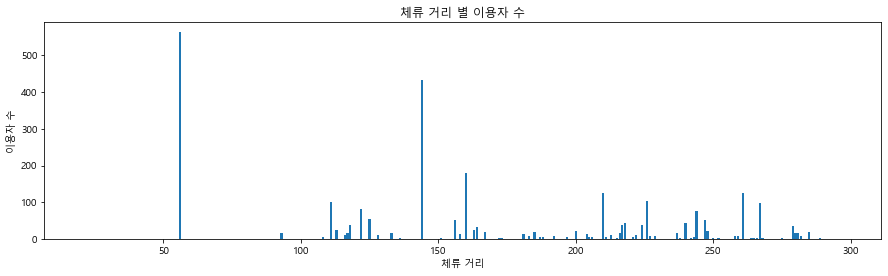

In [88]:
from matplotlib import pyplot as plt
def draw_walk_distance_count(x, y):
    plt.rcParams["figure.figsize"] = (15,4)
    plt.bar(x, y)
    plt.title('체류 거리 별 이용자 수')
    plt.xlabel("체류 거리")
    plt.ylabel("이용자 수")
    plt.show()
    
x = walk_distance_df['distance'][1:100]
y = walk_distance_df['num'][1:100]
draw_walk_distance_count(x, y)

In [80]:
y.describe()

count     10000.00000
mean         21.69100
std        1060.37147
min           1.00000
25%           1.00000
50%           3.00000
75%           6.00000
max      105910.00000
Name: num, dtype: float64

In [106]:
tourist_walk_df['num'] = 1
# tourist_walk_df[['stay_time', 'distance']].groupby(by=['stay_time', 'distance']).count().reset_index()
a = tourist_walk_df[['stay_time', 'distance', 'num']].groupby(by=['stay_time', 'distance']).count().reset_index()


,stay_time,distance,num
0,0,0,1473
104,1,0,1875
230,2,0,2554
412,3,0,2161
640,4,0,2637
...,...,...,...
73311,1247,69780,1
76708,1360,70139,3
76080,1337,73273,2
27402,143,74383,1


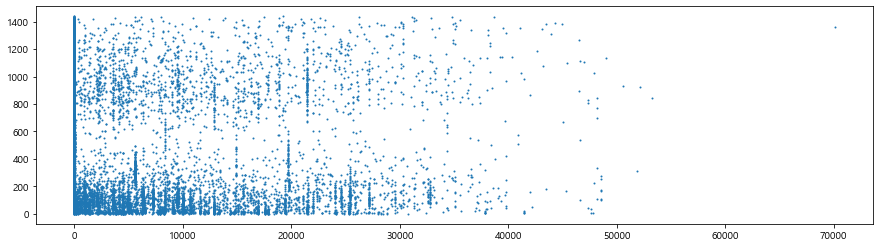

In [114]:
b = a[a['num']>=3]
x = b['distance']
y = b['stay_time']
plt.scatter(x, y, s=1)